# Topic Modeling

bioRxiv-medxiv files source: https://th-koeln.sciebo.de/s/oYPopaU7qxs0WzP

In [1]:
import os, json
import pandas as pd
import glob

path_json = '../data/'

temp = pd.DataFrame()

pattern = os.path.join(path_json,'*.json')
file_list = glob.glob(pattern)

for file in file_list:
    data = pd.read_json(file, lines=True)
    temp = temp.append(data, ignore_index=True)

temp.head()
abstract = temp.twitter_description
#temp.isnull().sum()



In [2]:
import scispacy
import en_core_sci_md
nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000



def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)] # remove numbers (e.g. from references [1], etc.)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()







# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.',
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [3]:

import numpy as np
import joblib
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

tf_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000) 

tf = tf_vectorizer.fit_transform(tqdm(abstract))

tf.shape


100%|██████████| 740/740 [00:01<00:00, 449.23it/s]


(740, 9732)

In [4]:
joblib.dump(tf_vectorizer, '../generated/tf_vectorizer.csv')
joblib.dump(tf, '../generated/tf.csv')

['../generated/tf.csv']

# Most frequent Words and LDA 50-80-30



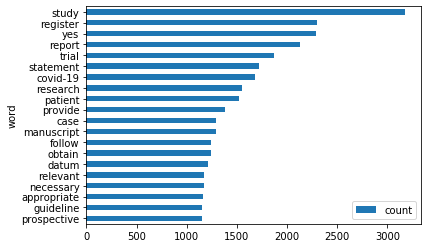

In [5]:
word_count = pd.DataFrame({'word': tf_vectorizer.get_feature_names(), 'count': np.asarray(tf.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [6]:
# this takes long! you can skip this and load the model from the output file
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0) # TODO: tune n_components: how many topics make sense?
lda_tf.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [7]:
joblib.dump(lda_tf, '../generated/lda.csv')

['../generated/lda.csv']

In [8]:
lda2 = LatentDirichletAllocation(n_components=80, random_state=0) # TODO: tune n_components: how many topics make sense?
lda2.fit(tf)
joblib.dump(lda2, '../generated/lda80.csv')

['../generated/lda80.csv']

In [9]:
lda3 = LatentDirichletAllocation(n_components=30, random_state=0) # TODO: tune n_components: how many topics make sense?
lda3.fit(tf)
joblib.dump(lda3, '../generated/lda30.csv')

['../generated/lda30.csv']

# Discover Topics

In [10]:
tfidf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tfidf_feature_names, 25)


Topic #0: sars-cov-2 ace2 infection antibody cell protein viral igg respiratory coronavirus expression live disease igm test patient human report find study cause covid-19 rna receptor lung

Topic #1: health work anxiety psychological worker risk participant survey response public factor hcws study covid-19 occupation quarantine report questionnaire mental provide high research disease score medical

Topic #2: sars-cov2 preventive trust practice behavior increase sars-cov-1 score ningbo minimum 3cl gp seek bioinformatics k.c magna wong impact conclude determinant potentially postdoctoral temperature odd central

Topic #3: severe disease covid-19 infection mortality high cell health sleep fmw risk excess condition death mtb significantly case indicate nlr substrate il-6 vaginal report disturbance curve

Topic #4: study yes register report trial statement china research manuscript datum provide obtain follow appropriate covid-19 relevant necessary guideline prospective interest case com

In [11]:
# slow, load from output file instead
topic_dist = pd.DataFrame(lda_tf.transform(tf))

In [12]:
topic_dist.to_csv('../generated/topic_dist.csv', index=False)

In [13]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9
0,0.003334,0.148536,0.003333,0.003334,0.003334,0.003334,0.003334,0.003334,0.003334,0.824793
1,0.000362,0.000362,0.000362,0.000362,0.996739,0.000362,0.000362,0.000362,0.000362,0.000362
2,0.001042,0.001042,0.001042,0.001042,0.001042,0.001042,0.193853,0.145627,0.001042,0.653227
3,0.000343,0.000342,0.000343,0.000342,0.000343,0.000343,0.669403,0.327857,0.000342,0.000343
4,0.109819,0.001021,0.001020,0.001021,0.001021,0.001021,0.142999,0.001021,0.314555,0.426504


In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
topic_dist.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

ValueError: Length mismatch: Expected axis has 10 elements, new values have 2 elements